## Compression via the PCA and the SVD
The main topic of this lesson is a data analysis method referred to as <i>Principal Components Analysis (PCA)</i>. The method requires computing the eigenvectors of a certain matrix; one way to compute those eigenvectors is to use a special factorization from linear algebra called the <i>Singular Value Decomposition (SVD)</i>.<br>

This notebook is simply a collection of notes with a little bit of code to help illustrate the main ideas. It does not have any exercises that you need to submit. However, you should try to understand all the code steps that appear in the subsection entitled, __Principal Components Analysis (PCA)__, as you will need to apply the SVD in a subsequent part of this assignment.<br>

__Motivation: data "compression."__ In previous lessons, we've looked at a few of the major tasks in data analysis: <i>ranking, regression, classification, and clustering</i>. Beyond these, the last problem you'll consider in our class is what we'll call <i>compression</i>.<br>

At a high level, the term compression simply refers to finding any compact representation of the data. Such representations can help us in two ways. First, it can make the data set smaller and therefore faster to process or analyze. Secondly, choosing a clever representation can reveal hidden structure.<br>

As a concrete example, consider the problem of <i>dimensionality reduction</i>: given a $d$-dimensional data set, we wish to transform it into a smaller $k$-dimensional data set where $k≤d$.<br>

Choosing the $k$ dimensions in a clever way might even reveal structure that is hard to see in all $d$ original dimensions. For instance, look at the examples at the "visualizing PCA" website:<br>
http://setosa.io/ev/principal-component-analysis/

## Data: Nutrition in the UK
Here is one of those examples, which is nutritional data gathered in a study of four countries of the United Kingdom. (Researchers tabulated the average number of grams consumed per week by an individual living in a particular country, broken down along various food and drink categories.)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline

In [2]:
import requests
import os
import hashlib
import io

def on_vocareum():
    return os.path.exists('.voc')

def download(file, local_dir="", url_base=None, checksum=None):
    local_file = "{}{}".format(local_dir, file)
    if not os.path.exists(local_file):
        if url_base is None:
            url_base = "https://cse6040.gatech.edu/datasets/"
        url = "{}{}".format(url_base, file)
        print("Downloading: {} ...".format(url))
        r = requests.get(url)
        with open(local_file, 'wb') as f:
            f.write(r.content)
            
    if checksum is not None:
        with io.open(local_file, 'rb') as f:
            body = f.read()
            body_checksum = hashlib.md5(body).hexdigest()
            assert body_checksum == checksum, \
                "Downloaded file '{}' has incorrect checksum: '{}' instead of '{}'".format(local_file,
                                                                                           body_checksum,
                                                                                           checksum)
    print("'{}' is ready!".format(file))
    
if on_vocareum():
    URL_BASE = "https://cse6040.gatech.edu/datasets/uk-food/"
    DATA_PATH = "../resource/lib/publicdata/uk-food/"
else:
    URL_BASE = "https://github.com/cse6040/labs-fa17/raw/master/datasets/uk-food/"
    DATA_PATH = ""

datasets = {'uk-nutrition-data.csv': 'a6cdc2fb658bacfdf50797c625aa3815'}

for filename, checksum in datasets.items():
    download(filename, local_dir=DATA_PATH, url_base=URL_BASE, checksum=checksum)
    
print("\n(All data appears to be ready.)")

'uk-nutrition-data.csv' is ready!

(All data appears to be ready.)


17 x 5 table of data:


,Product,England,Northern Ireland,Scotland,Wales
0,Alcoholic drinks,375,135,458,475
1,Beverages,57,47,53,73
2,Meat,245,267,242,227
3,Cereals,1472,1494,1462,1582
4,Cheese,105,66,103,103


...


Text(0.5,0.98,'Grams per week per person')

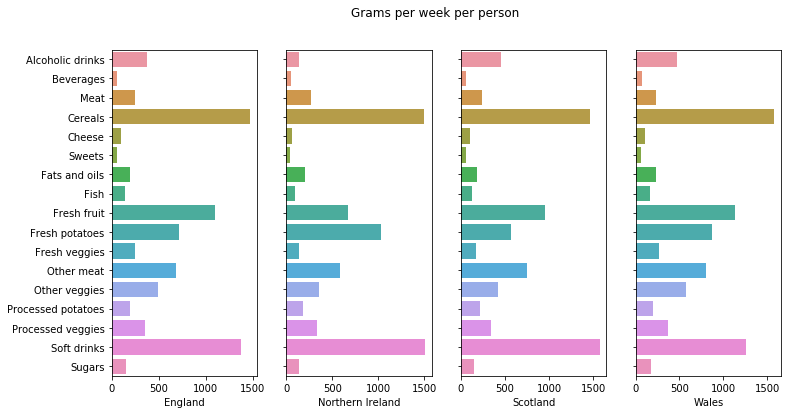

In [3]:
df_uk = pd.read_csv('{}uk-nutrition-data.csv'.format(DATA_PATH))
print("{} x {} table of data:".format(df_uk.shape[0], df_uk.shape[1]))
display(df_uk.head ())
print("...")

fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True)
countries = df_uk.columns.difference(['Product'])
for i in range(len(countries)):
    sns.barplot(x=countries[i], y='Product', data=df_uk, ax=axes[i])
    axes[i].set_ylabel("")
fig.suptitle("Grams per week per person")

Do the countries differ in any significant way? Looking only at the bar charts, it is probably hard to tell unless you are very perceptive, and in any case, visual inspection is a very <i>ad hoc</i> technique. Is there a more systematic way?

## Principal components analysis (PCA)
The method of <i>principal components analysis</i> (PCA) is one such technique. For this example, it would start by viewing these data as four (4) data points, one for each country, embedded in a 17-dimensional space (one dimension per food category). The following page will help build your intuition for PCA; the notes that then follow below show formally how PCA works and derives an algorithm to compute it.

http://setosa.io/ev/principal-component-analysis/

## Basic definitions
__Input data matrix, centered.__ Per our usual conventions, let $x̂ 0,…,x̂ m−1$ be the $m$ data points, where each $xi∈ℝd$ is a single observation. Each observation is represented by a $d$-dimensional real-valued vector corresponding to $d$ measured predictors. As usual, we can stack these into a data matrix, denoted $X≡⎛⎝⎜⎜⎜x̂ T0⋮x̂ Tm−1⎞⎠⎟⎟⎟$.

However, we'll add one more important assumption: these data should be centered about their mean, i.e., $1m∑m−1i=0x̂ i=0$. If the observations are not centered initially, then preprocess them accordingly.

__Projections.__ Let $φ∈ℝd$ be a vector of unit length, i.e., $‖φ‖22=φTφ=1$. The projection of a data point $x̂ i$ onto $φ$ is $x̂ Tiφ$, which measures the length of the projected vector.

The following code cell illustrates a projection. Given a vector <code>x_hat</code> and a line represented by a unit vector <code>phi</code>, it computes the projection  <code>x_hat_proj_phi</code> of <code>x_hat</code> onto <code>phi</code>.

In [4]:
# Define a projection
x_hat = np.array([0.25, 0.75]) # Vector to project
phi = np.array([0.5, 0.25]) ; phi = phi / np.linalg.norm(phi) # Unit vector onto which to project x_hat
x_hat_proj_phi = x_hat.T.dot(phi) * phi # Carry out the projection

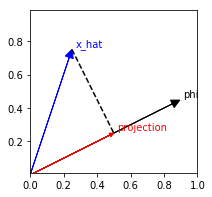

* Black arrow: `phi` (len=1.000)
* Blue arrow: `x_hat` (len=0.791)
* Red arrow: projection of `x_hat` onto `phi` (len=0.559)


In [5]:
# Visualize the projection (you don't need to understand this code cell in any detail)
import matplotlib.lines as mlines

plt.figure(figsize=(3, 3))
ax = plt.axes()
ax.arrow(0, 0, x_hat[0], x_hat[1], head_width=0.05, head_length=0.05, fc='b', ec='b', length_includes_head=True)
ax.arrow(0, 0, phi[0], phi[1], head_width=0.05, head_length=0.05, fc='k', ec='k', length_includes_head=True)
ax.arrow(0, 0, x_hat_proj_phi[0], x_hat_proj_phi[1], head_width=0.025, head_length=0.025, fc='r', ec='r', length_includes_head=True)

perp_line = mlines.Line2D([x_hat[0], x_hat_proj_phi[0]],
                          [x_hat[1], x_hat_proj_phi[1]],
                          linestyle='--', color='k')
ax.add_line(perp_line)
ax.axis('equal') # Equal ratios, so you can tell what is perpendicular to what
ax.axis([0, 1, 0, 1])

dx, dy = 0.02, 0.02
plt.annotate('x_hat', xy=(x_hat[0]+dx, x_hat[1]+dy), color='b')
plt.annotate('phi', xy=(phi[0]+dx, phi[1]+dy), color='k')
plt.annotate('projection', xy=(x_hat_proj_phi[0]+dx, x_hat_proj_phi[1]+dy), color='r')

plt.show()

msg = """* Black arrow: `phi` (len={:.3f})
* Blue arrow: `x_hat` (len={:.3f})
* Red arrow: projection of `x_hat` onto `phi` (len={:.3f})"""
print(msg.format(np.linalg.norm(phi),
                 np.linalg.norm(x_hat),
                 np.linalg.norm(x_hat_proj_phi)))

## Maximizing projections
If the length of a projected data point is large, then intuitively, we have "preserved" its shape. So let's think of the total length of projections of all the data points as a measure of cost, which we can then try to maximmize.

__Projection cost.__ Let $J(φ)$ be a cost function that is proportional to the mean squared projections of the data onto $φ$:

$J(ϕ)≡12m∑i=0m−1(x̂ Tiφ)2$.
 
The additional factor of "1/2" is for aesthetic reasons. (It cancels out later on.)

Let's also apply some algebra-fu to the right-hand side to put it into a more concise matrix form:

$J(ϕ)==≡12φT(1m∑i=0m−1x̂ ix̂ Ti)φ12φT(1mXTX)φ12φTCφ.$
 
In the last step, we defined $C≡1mXTX$. In statistics, if $X$ represents mean-centered data, then the matrix $C$ is also known as the <a href="https://en.wikipedia.org/wiki/Sample_mean_and_covariance">sample covariance matrix</a> of the data.


__Principal components via maximizing projections.__ There are several ways to formulate the PCA problem. Here we consider the one based on <i>maximizing projections</i>.

Start by defining a <i>principal component</i> of the data $X$ to be a vector, $φ$, of unit length that maximizes the sum of squared projections.

To convert this definition into a formal problem, there is a technique known as the <i>method of Langrange multipliers</i>, which may be applied to any minimization or maximization problem that has equality constraints. The idea is to modify the cost function in a certain way that effectively incorporates each constraint: for each constraint you will add to the cost function a term proportional to a dummy parameter times some form of the constraint.

Huh? It's easiest to see this formulation by example. In the case of a principal component, the modified cost function is
$Ĵ (φ,λ)≡J(φ)+λ2(1−φTφ)$,
 
where the second term captures the constraint: it introduces a dummy optimization parameter, $λ$, times the constraint that $φ$ has unit length, i.e., $‖φ‖22=φTφ=1$, or $1−φTφ=0$.

The reason to add the constraint in this way should become clear momentarily.

As before, the factor of "1/2" is there solely for aesthetic reasons and will "cancel out," as you'll soon see.

The optimization task is to find the $φ∗$ and $λ∗$ that maximize $Ĵ$:

$(φ∗,λ∗)≡argmaxφ,λĴ (φ,λ).$

To solve this optimization problem, you just need to "take derivatives" of $Ĵ$ with respect to $φ$ and $λ$, and then set these derivatives to 0.

__Exercise (optional).__ Show that
$∇φĴ ∂∂λĴ ==Cφ−λφ12(1−φTφ).$
 
Setting these to zero and solving yields the following computational problem:
$Cφ=1mXTXφ‖φ‖22==λφ1.$

Is it now clear why the constraint was incorporated into $Ĵ$ as it was? Doing so produces a second equation that exactly captures the constraint!

This problem is an <i>eigenproblem</i>, which is the task of computing an eigenvalue and its corresponding eigenvector of $C=1mXTX$.

The matrix $C$ will usually have many eigenvalues and eigenvectors. So which one do you want? Plug the eigenvector back into the original cost function. Then, $J(φ)=12φTCφ=λ2φTφ=λ2$. In other words, to maximize $J(φ)$ you should pick the $φ$ with the largest eigenvalue $λ$.

### Finding an eigenpair via the SVD
So how do you find the eigenvectors of $C$? That is, what algorithm will compute them?

One way is to form $C$ explicitly and then call an off-the-shelf eigensolver. However, forming $C$ explicitly from the data $X$ may be costly in time and storage, not to mention possibly less accurate. (Recall the condition number blow-up problem in the case of solving the normal equations.)

Instead, we can turn to the "Swiss Army knife" of linear algebra, which is the singular value decomposition, or SVD. It is an extremely versatile tool for simplifying linear algebra problems. It can also be somewhat expensive to compute accurately, but a lot of scientific and engineering effort has gone into building robust and reasonably efficient SVD algorithms. So let's assume these exist -- and they do in both <a href="http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html">Numpy</a> and <a href="http://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html">Scipy</a> -- and use them accordingly.

__The SVD.__ Every real-valued matrix $X∈ℝm×d$ has a singular value decomposition. Let $s=min(m,d)$, i.e., the smaller of the number of rows or columns. Then the SVD of $X$ is the factorization, $X=UΣVT$, where $U$, $Σ$, and $VT$ are defined as follows.

The matrices $U∈ℝm×s$ and $V∈ℝd×s$ are orthogonal matrices, meaning $UTU=I$ and $VTV=I$; and the matrix $Σ$ is an $s×s$ diagonal matrix.

Note that $V$ is taken to be $d×s$, so that the $VT$ that appears in $UΣVT$ is $s×d$.

The columns of $U$ are also known as the left singular vectors, and the columns of $V$ are the right singular vectors of $X$. Using our usual "column-view" of a matrix, these vectors are denoted by $ui$ and $vi$:

$UV==[u0u1⋯us−1][v0v1⋯vs−1]$
 
Regarding the diagonal matrix $Σ$, its entries are, collectively, called the singular values of $X$

⎡⎣⎢⎢⎢⎢σ0σ1⋱σs−1⎤⎦⎥⎥⎥⎥.

From these definitions, the SVD implies that $XV=UΣ$. This form is just a compact way of writing down a system of independent vector equations, $Xvi=σiui$.

Recall that in PCA, you want to evaluate $C=1mXTX$. In terms of the SVD, $XTX=VΣTUTUΣVT=VΣ2VT$, or $XTXV=VΣ2$.

This relation may in turn be rewritten as the system of vector equations, $XTXvi=σ2ivi$.

In other words, every pair $(φ,λ)≡(vi,σ2im)$ is a potential solution to the eigenproblem, $Cφ=1mXTXφ=λφ$. The pair with the largest eigenvalue is $(v0,σ20m)$.

In [ ]:
from IPython.display import HTML
HTML(filename='part0.html')